<a href="https://colab.research.google.com/github/nightKnight112/Bin_with_a_Brain/blob/main/model_p_final_humanvnon-human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model to predict if the intrusion is Human or Not-Human

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

import keras
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization

**Data**

The dataset contains images divided into two classes: human and non-human and it is split into **train data (75%) and test data (25%). Training dataset contains 8018 images while test dataset 2724 images** The data is imported into the colab from here as **archive_hvnh.zip**

**The Train and Validation splits of the dataset at 75% and 25%**

The validation part(test_set) is again split into 10% and 90% for validation and testing respectively

Extracting the dataset from a zip file

In [ ]:
from zipfile import ZipFile
zf = ZipFile('/content/drive/MyDrive/archive_hvnh.zip', 'r')
zf.extractall()
zf.close()

In [ ]:
train_dir = '/content/human-and-non-human/training_set/training_set'
test_dir = '/content/human-and-non-human/test_set/test_set'

**Data augumentation**

We use **ImageDataGenerator** to create a transformation that rescales the images and applied data augmentation as well. We generate augumentation only for train data while validation data are only rescaling ones.

**Keras ImageDataGenerator** class is used which provides a quick and easy way to label all of our images based on the directories they are in. Also, it provides many of different augmentation techniques like standardization, shifts, rotation, flips, brightness change etc.

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255
                                   )


val_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.1) #rescaling for normalization of image features

Now we set our dataset into train, test and validation data.

We use the **flow_from_directory()** method which allows to read the images directly from the directory and augment them while the neural network model is learning on the training data.

In [ ]:
Batch_size = 32  # we can also take the batch size at 64, but taking 32 as the batch size provides the most optimal methods

train_set = train_datagen.flow_from_directory(train_dir, class_mode='binary',
                                              batch_size = Batch_size,
                                              target_size=(150, 150)) #flow_from_directory func takes the directory name as the label and labels all the imgs in it
                                              #initial img input into network is 64 * 64 * 3


val_set = val_datagen.flow_from_directory(test_dir, class_mode='binary',
                                          batch_size = Batch_size,
                                          target_size=(150, 150),
                                          subset= 'training')
   

test_set = val_datagen.flow_from_directory(test_dir, class_mode = 'binary',
                                           batch_size = Batch_size, 
                                           target_size=(150, 150),
                                           subset= 'validation')

Found 8017 images belonging to 2 classes.
Found 2452 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


**Class Indices**

In [ ]:
train_set.class_indices

{'humans': 0, 'non-humans': 1}

In [ ]:
train_set.image_shape

(150, 150, 3)

**Model Creation**

In [ ]:

model = Sequential([                
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dense(units=1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

**Optimal LR finding function for the model**

In [ ]:
#model.compile(loss='binary_crossentropy',
            # optimizer=tf.keras.optimizers.experimental.RMSprop(lr=1e-4),
            # metrics=['acc'])

def adjust_learning_rate(model, dataset):
        
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.experimental.RMSprop()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["accuracy"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [10]:
#his = adjust_learning_rate(model, train_set)  # for learning rate optimization if required
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=1e-4),
             metrics=['acc'])
history = model.fit(train_set,
                    steps_per_epoch=100,
                    epochs= 30,
                    validation_steps=50,
                    validation_data=val_set)

Epoch 1/30
100/100 [==============================] - 197s 2s/step - loss: 0.4528 - acc: 0.7780 - val_loss: 0.2959 - val_acc: 0.8838
Epoch 2/30
100/100 [==============================] - 194s 2s/step - loss: 0.2578 - acc: 0.8972 - val_loss: 0.2265 - val_acc: 0.9062
Epoch 3/30
100/100 [==============================] - 193s 2s/step - loss: 0.2311 - acc: 0.9097 - val_loss: 0.2737 - val_acc: 0.8988
Epoch 4/30
100/100 [==============================] - 192s 2s/step - loss: 0.1828 - acc: 0.9306 - val_loss: 0.1607 - val_acc: 0.9362
Epoch 5/30
100/100 [==============================] - 195s 2s/step - loss: 0.1560 - acc: 0.9388 - val_loss: 0.2080 - val_acc: 0.9175
Epoch 6/30
100/100 [==============================] - 193s 2s/step - loss: 0.1482 - acc: 0.9447 - val_loss: 0.1512 - val_acc: 0.9394
Epoch 7/30
100/100 [==============================] - 194s 2s/step - loss: 0.1296 - acc: 0.9556 - val_loss: 0.2241 - val_acc: 0.9087
Epoch 8/30
100/100 [==============================] - 192s 2s/step - 

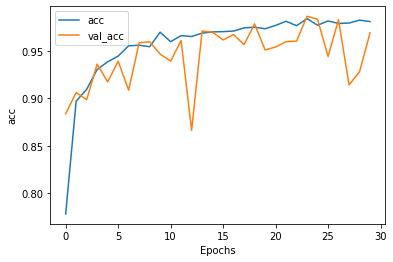

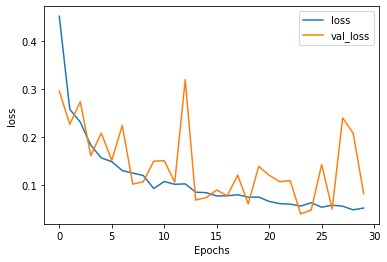

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [12]:
loss, accuracy = model.evaluate(test_set, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Accuracy in %: ", accuracy*100)

Testing Accuracy:  0.9742
Accuracy in %:  97.41697311401367
